In [1]:
import h5py
import json
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from dyn_net.utils.criticality import find_theta_c_from_degree_distribution

# USEFUL FUNCTION FOR DATA ANALYSIS #
def find_repo_root() -> Path:
    return next(p for p in Path.cwd().parents if (p / "pyproject.toml").exists())


def read_stats_df(stats_path: Path) -> pd.DataFrame:
    with h5py.File(stats_path, "r", swmr=True) as fh:
        dset = fh["stats"]
        dset.refresh()
        fieldnames = [s.decode("utf-8") for s in dset.attrs["fieldnames"]]
        return pd.DataFrame(dset[...], columns=fieldnames)


def read_aggregate_dfs(agg_path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    with h5py.File(agg_path, "r", swmr=True) as fh:
        mean_dset = fh["mean"]
        std_dset = fh["std"]
        mean_dset.refresh()
        std_dset.refresh()
        field_attr = fh.attrs.get("fieldnames")
        if field_attr is None:
            raise ValueError(f"Missing fieldnames in {agg_path}")
        fieldnames = [s.decode("utf-8") for s in np.asarray(field_attr).tolist()]
        mean_df = pd.DataFrame(mean_dset[...], columns=fieldnames)
        std_df = pd.DataFrame(std_dset[...], columns=fieldnames)
        return mean_df, std_df


def read_state_df(state_path: Path) -> pd.DataFrame:
    with h5py.File(state_path, "r", swmr=True) as fh:
        dset_state = fh["state"]
        dset_time = fh["time"]
        dset_step = fh["step"]
        dset_state.refresh()
        dset_time.refresh()
        dset_step.refresh()
        state = dset_state[...]
        df = pd.DataFrame(state, columns=[f"x_{i}" for i in range(state.shape[1])])
        df.insert(0, "t", dset_time[...])
        df.insert(0, "step", dset_step[...])
        return df


def read_timings(timings_path: Path) -> dict:
    return json.loads(Path(timings_path).read_text())


def read_config(config_path: Path) -> dict:
    return json.loads(Path(config_path).read_text())


def list_phase_diagram_runs(base_dir: Path) -> list[Path]:
    base_dir = Path(base_dir)
    run_dirs = [p for p in base_dir.iterdir() if p.is_dir() and p.name.startswith("row_")]
    return sorted(run_dirs, key=lambda p: p.name)


# Summarize mean_x1: across-realization variance and time variability over the tail window.
def summarize_mean_x1_aggregate(agg_path: Path, frac: float = 0.8, use_abs: bool = False) -> dict:
    mean_df, std_df = read_aggregate_dfs(agg_path)
    with h5py.File(agg_path, "r", swmr=True) as fh:
        count = int(fh["count"][()])
    col = "deg_weighted_mean_x1_abs" if use_abs else "deg_weighted_mean_x1"
    if col not in mean_df.columns:
        raise ValueError(f"{col} column missing from aggregate.")
    if "t" not in mean_df.columns:
        raise ValueError("t column missing from aggregate.")
    t_max = float(mean_df["t"].max())
    t_start = frac * t_max
    tail = mean_df[mean_df["t"] >= t_start]
    if tail.empty:
        raise ValueError("No samples in tail window; check frac/t_max.")
    series = tail[col]
    time_var = float(series.var(ddof=0))
    time_std = float(np.sqrt(time_var))
    tail_std = std_df.loc[tail.index, col]
    return {
        "mean_x1": float(series.mean()),
        "time_var_x1": time_var,
        "time_std_x1": time_std,
        "var_x1": float((tail_std ** 2).mean()),
        "t_start": float(tail["t"].iloc[0]),
        "t_end": float(tail["t"].iloc[-1]),
        "count": count,
    }


# Compute theta_c from the config used for the sweep (theta value is ignored).
def compute_theta_c_from_config_data(config_used: dict, *, theta_bracket=(1e-6, 1.0)) -> float:
    degree_distribution = config_used["network"]["params"]["degree_distribution"]
    sigma = float(config_used["noise"]["params"]["sigma"])
    return find_theta_c_from_degree_distribution(
        degree_distribution=degree_distribution,
        sigma=sigma,
        theta_bracket=theta_bracket,
    )


# Compute theta_c from a config file on disk.
def compute_theta_c_from_config(config_path: Path, *, theta_bracket=(1e-6, 1.0)) -> float:
    config_used = read_config(config_path)
    return compute_theta_c_from_config_data(config_used, theta_bracket=theta_bracket)


# Build a per-run table by reading each row_*/aggregate.h5 and config_used.json.
def build_phase_diagram(
    sweep_dir: Path,
    sweep_table: pd.DataFrame | None = None,
    *,
    frac: float = 0.8,
    theta_c: float | None = None,
) -> pd.DataFrame:
    sweep_dir = Path(sweep_dir)
    rows = []

    if sweep_table is not None:
        if theta_c is None:
            raise ValueError("theta_c is required when using a sweep table")
        run_to_theta = dict(zip(sweep_table["run_id"], sweep_table["system.params.theta"]))
        for run_id, theta in run_to_theta.items():
            run_dir = sweep_dir / str(run_id)
            agg_path = run_dir / "aggregate.h5"
            if not agg_path.exists():
                print(str(agg_path) + " not found")
                continue
            theta = float(theta)
            use_abs = theta_c is not None and theta > theta_c
            summary = summarize_mean_x1_aggregate(agg_path, frac=frac, use_abs=use_abs)
            rows.append({
                "run": run_id,
                "theta": theta,
                "use_abs": use_abs,
                **summary,
            })
        return pd.DataFrame(rows)

    run_dirs = list_phase_diagram_runs(sweep_dir)
    if not run_dirs:
        raise ValueError(f"No row_* subfolders found in {sweep_dir}")

    if theta_c is None:
        first_cfg = read_config(run_dirs[0] / "config_used.json")
        theta_c = compute_theta_c_from_config_data(first_cfg)

    for run_dir in run_dirs:
        agg_path = run_dir / "aggregate.h5"
        if not agg_path.exists():
            print(str(agg_path) + " not found")
            continue
        cfg_path = run_dir / "config_used.json"
        if not cfg_path.exists():
            print(str(cfg_path) + " not found")
            continue
        config_used = read_config(cfg_path)
        theta = float(config_used["system"]["params"]["theta"])
        use_abs = theta > theta_c
        summary = summarize_mean_x1_aggregate(agg_path, frac=frac, use_abs=use_abs)
        rows.append({
            "run": run_dir.name,
            "theta": theta,
            "use_abs": use_abs,
            **summary,
        })

    phase_df = pd.DataFrame(rows)
    if not phase_df.empty:
        phase_df = phase_df.sort_values("theta").reset_index(drop=True)
    return phase_df


## Analysis of "single" numerical simulations

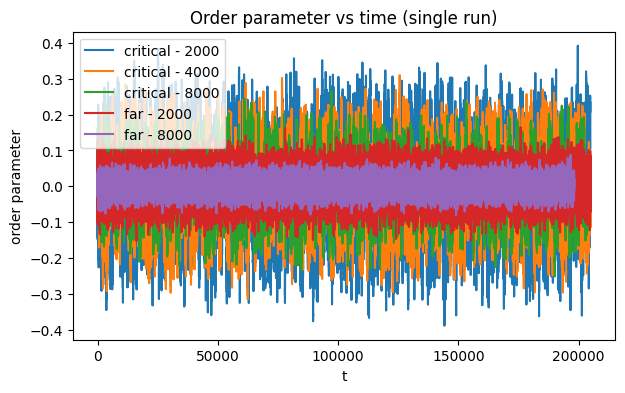

In [53]:
# Read outputs produced by prototyping_simulations.ipynb (stats.h5/state.h5)
repo_root = find_repo_root()

stats = {}
for label in ["critical","far"]:
    stats[label] = {}
    for N in [2000,4000,8000]:
        try:
            sim_output_dir = repo_root / f"results/linear_response/all_to_all/unperturbed_runs/{label}/n{N}/graph_0001"
            stats_path = sim_output_dir / 'stats.h5'
            state_path = sim_output_dir / 'state.h5'

            stats_df = read_stats_df(sim_output_dir / "stats.h5")
            stats[label][N] = stats_df
        except:
            continue
        
fig, ax = plt.subplots(figsize=(7, 4))
for label, item in stats.items():
    for N , df in item.items():
        df.plot(x='t', y='mean_x', ax=ax, label=f"{label} - {N}")
# # # if 'mean_x1_abs' in stats_df.columns:
# # #     stats_df.plot(x='t', y='mean_x1_abs', ax=ax, label='mean_x1_abs', alpha=0.7)
ax.set_xlabel('t')
ax.set_ylabel('order parameter')
ax.set_title('Order parameter vs time (single run)')
ax.legend()

(-30.0, 1200.0)

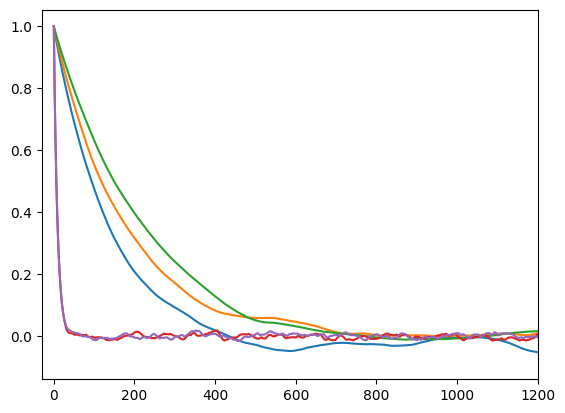

In [56]:
from scipy.signal import correlate


transient = 5000
fig , ax = plt.subplots()

for label, item in stats.items():
    for N , df in item.items():
        df = df[df.t > transient]
        t = df["t"].values
        obs = df["mean_x"].values

        dt = t[1] - t[0]

        signal = obs - obs.mean()
        corr = correlate(signal,signal,mode="full")
        corr = corr[corr.size // 2 : ] / signal.size
        lags = np.arange(0,signal.size) * dt

        
        ax.plot(lags,corr /corr[0],label=f"{label} - {N}")

ax.set_xlim(-30,1200)

## Phase diagram

Aggregate the sweep results and plot order parameter vs. theta.


<Axes: xlabel='t'>

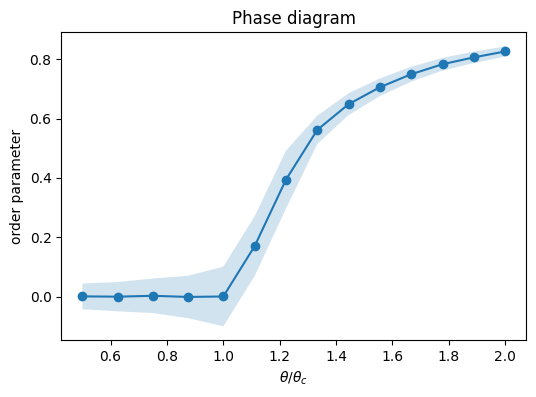

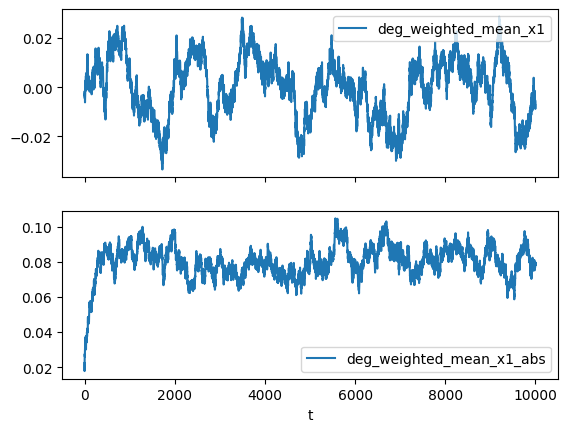

In [51]:
# Aggregate across runs for each theta and plot the order parameter.
repo_root = find_repo_root()
phase_diagram_base_folder = repo_root / "results/phase_diagram/poisson/n1000"

run_dirs = list_phase_diagram_runs(phase_diagram_base_folder)
# Compute theta_c from the first config_used.json (theta itself is ignored).
theta_c = compute_theta_c_from_config(run_dirs[0] / "config_used.json")
config = read_config(run_dirs[0] / "config_used.json")
phase_df = build_phase_diagram(
    phase_diagram_base_folder,
    frac=0.7,
    theta_c=theta_c,
)
phase_df["theta_scaled"] = phase_df["theta"] / theta_c
phase_df["std"] = np.sqrt(phase_df["var_x1"])

fig, ax = plt.subplots(figsize=(6, 4))
phase_df.plot(x="theta_scaled", y="mean_x1", marker="o", ax=ax, legend=False)
ax.fill_between(
    phase_df["theta_scaled"],
    phase_df["mean_x1"] - phase_df["std"],
    phase_df["mean_x1"] + phase_df["std"],
    alpha=0.2,
)
ax.set_xlabel(r"$\theta/\theta_c$")
ax.set_ylabel("order parameter")
ax.set_title("Phase diagram")

# Inspect one run's time series
fig,ax = plt.subplots(nrows=2,sharex=True)
mean_df, std_df = read_aggregate_dfs(run_dirs[4] / "aggregate.h5")
mean_df.plot(x="t", y="deg_weighted_mean_x1",ax=ax[0])
mean_df.plot(x="t", y="deg_weighted_mean_x1_abs",ax=ax[1])


## Response Experiments Analysis
Analyse aggregated response results (mean/std over time for +/- epsilon).


In [ ]:
# Read outputs produced by prototyping_simulations.ipynb (stats.h5/state.h5)
repo_root = find_repo_root()
sim_output_dir = repo_root / "results/linear_response/poisson/critical/unperturbed_runs/n1000/graph_0001"
stats_path = sim_output_dir / 'stats.h5'
state_path = sim_output_dir / 'state.h5'

with h5py.File(state_path, "r") as h5f:
        state_dset = h5f["state"]
        time_dset = h5f["time"]
        times = np.asarray(time_dset[...], dtype=float)

        df = np.asarray(state_dset[int(1000),:], dtype=float).reshape(-1) 
        
df_stats = read_stats_df(stats_path)
df_stats.plot(x='t',y='mean_x1')

In [ ]:
repo_root = find_repo_root()
sim_output_dir = repo_root / "results/linear_response/poisson/critical/perturbed_runs/n1000/graph_0001/response"
aggregate_path = sim_output_dir / 'aggregate.h5'

config = read_config(sim_output_dir / "config_used.json")
h5f = h5py.File(aggregate_path,"r",swmr=True)

df_plus = h5f["mean_plus"][...]
df_minus = h5f["mean_minus"][...]
field_attr = h5f.attrs.get("fieldnames")
fieldnames = [s.decode("utf-8") for s in np.asarray(field_attr).tolist()]
print(dict(h5f.attrs))
h5f.close()

df_plus = pd.DataFrame(df_plus,columns=fieldnames)
df_minus = pd.DataFrame(df_minus,columns=fieldnames)
epsilon = config.get("perturbation").get("epsilon")

df_response = (df_plus - df_minus) / (2*epsilon)
df_response['t'] = df_plus["t"]

df_quad = (df_plus + df_minus) / (2*epsilon**2)
df_quad['t'] = df_plus["t"]

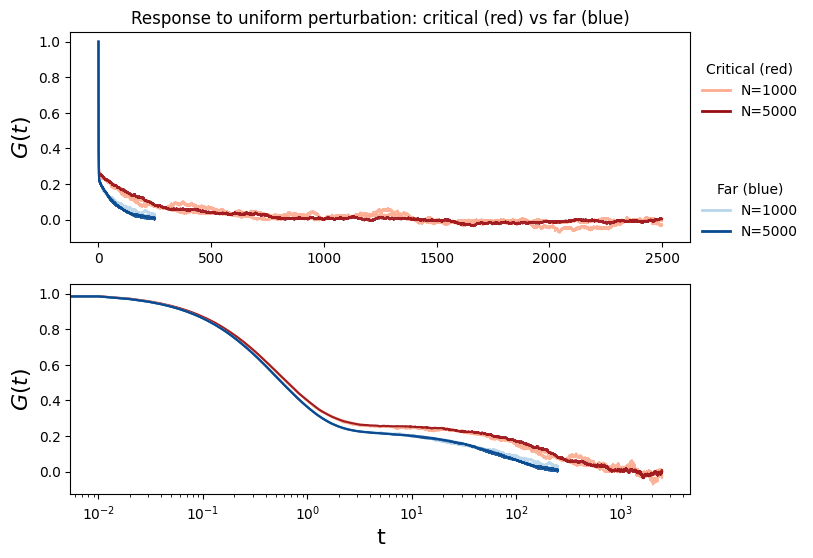

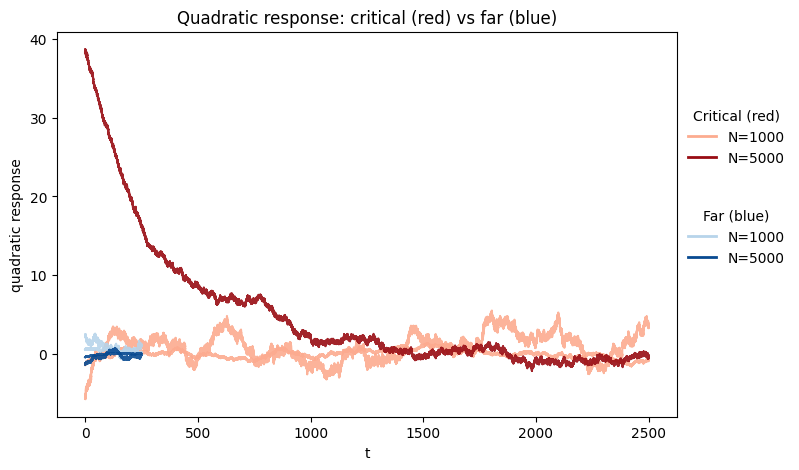

In [2]:
# Plot response linearity across eps for each N (critical in red, far in blue)
repo_root = find_repo_root()

def _read_response_aggregate(path):
    with h5py.File(path, 'r') as h5f:
        mean_plus = h5f['mean_plus'][...]
        mean_minus = h5f['mean_minus'][...]
        field_attr = h5f.attrs.get('fieldnames')
        fieldnames = [s.decode('utf-8') for s in np.asarray(field_attr).tolist()]
        sample_count = int(h5f.attrs.get('sample_count', 0))
    df_plus = pd.DataFrame(mean_plus, columns=fieldnames)
    df_minus = pd.DataFrame(mean_minus, columns=fieldnames)
    return df_plus, df_minus, sample_count

def _collect_response_series(base_dir):
    data = {}  # N -> list of (eps_tag, graph_tag, df_plus, df_minus, epsilon, sample_count)
    if not base_dir.exists():
        return data
    for n_dir in sorted(base_dir.glob('n*')):
        if not n_dir.is_dir() or not n_dir.name.startswith('n'):
            continue
        try:
            n_val = int(n_dir.name[1:])
        except ValueError:
            continue
        runs = []
        for graph_dir in sorted(n_dir.glob('graph_*')):
            graph_tag = graph_dir.name
            eps_dirs = sorted(graph_dir.glob('eps*/'))
            for eps_dir in eps_dirs:
                agg_path = eps_dir / 'aggregate.h5'
                cfg_path = eps_dir / 'config_used.json'
                if not agg_path.exists() or not cfg_path.exists():
                    continue
                config = read_config(cfg_path)
                eps = config.get('perturbation', {}).get('epsilon')
                if eps is None:
                    continue
                try:
                    df_plus, df_minus, sample_count = _read_response_aggregate(agg_path)
                except Exception as exc:
                    print(f'Skip {agg_path}: {exc}')
                    continue
                eps_tag = eps_dir.parent.name  # eps001, etc.
                runs.append((eps_tag, graph_tag, df_plus, df_minus, float(eps), sample_count))
        if runs:
            data[n_val] = runs
    return data

def _color_map(ns, cmap_name):
    ns_sorted = sorted(ns)
    cmap = plt.get_cmap(cmap_name)
    colors = {}
    if len(ns_sorted) == 1:
        colors[ns_sorted[0]] = cmap(0.7)
        return colors
    for i, n_val in enumerate(ns_sorted):
        frac = 0.3 + 0.6 * (i / (len(ns_sorted) - 1))
        colors[n_val] = cmap(frac)
    return colors

def plot_response_all_in_one():
    critical_dir = repo_root / 'results/linear_response/poisson/perturbed_runs/critical'
    far_dir = repo_root / 'results/linear_response/poisson/perturbed_runs/far'

    critical_data = _collect_response_series(critical_dir)
    far_data = _collect_response_series(far_dir)

    all_ns = sorted(set(critical_data.keys()) | set(far_data.keys()))
    red_map = _color_map(all_ns, 'Reds')
    blue_map = _color_map(all_ns, 'Blues')

    fig, (ax_lin, ax_log) = plt.subplots(nrows=2, figsize=(8, 6), sharex=False)
    ax_log.set_xscale('log')
    for n_val, runs in sorted(critical_data.items()):
        for eps_tag, graph_tag, df_plus, df_minus, eps, sample_count in runs:
            df_response = (df_plus - df_minus) / (2.0 * eps)
            if 't' in df_plus.columns:
                df_response['t'] = df_plus['t']
            if 'mean_x1' in df_response.columns:
                ax_lin.plot(df_response['t'], df_response['mean_x1'], color=red_map[n_val], alpha=0.9)
                ax_log.plot(df_response['t'], df_response['mean_x1'], color=red_map[n_val], alpha=0.9)
    for n_val, runs in sorted(far_data.items()):
        for eps_tag, graph_tag, df_plus, df_minus, eps, sample_count in runs:
            df_response = (df_plus - df_minus) / (2.0 * eps)
            if 't' in df_plus.columns:
                df_response['t'] = df_plus['t']
            if 'mean_x1' in df_response.columns:
                ax_lin.plot(df_response['t'], df_response['mean_x1'], color=blue_map[n_val], alpha=0.9)
                ax_log.plot(df_response['t'], df_response['mean_x1'], color=blue_map[n_val], alpha=0.9)

    ax_lin.set_title('Response to uniform perturbation: critical (red) vs far (blue)')
    ax_log.set_xlabel('t', size=16)
    ax_lin.set_ylabel(r'$G(t)$', size=16)
    ax_log.set_ylabel(r'$G(t)$', size=16)

    # Separate legends for critical (red) and far (blue) on the top axis
    # Legends outside the axes

    # Figure-level legend outside the subplots
    handles_red = [plt.Line2D([0], [0], color=red_map[n], lw=2) for n in sorted(all_ns)]
    handles_blue = [plt.Line2D([0], [0], color=blue_map[n], lw=2) for n in sorted(all_ns)]
    labels = [f'N={n}' for n in sorted(all_ns)]
    leg1 = fig.legend(handles_red, labels, title='Critical (red)', loc='upper right', bbox_to_anchor=(1.05, 0.85), frameon=False)
    fig.legend(handles_blue, labels, title='Far (blue)', loc='upper right', bbox_to_anchor=(1.05, 0.65), frameon=False)
    #fig.savefig("../../figures/GreensFunctionUniformPerturbation.png",bbox_inches="tight",dpi=300)
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 5))
    for n_val, runs in sorted(critical_data.items()):
        for eps_tag, graph_tag, df_plus, df_minus, eps, sample_count in runs:
            df_quad = (df_plus + df_minus) / (2.0 * eps * eps)
            if 't' in df_plus.columns:
                df_quad['t'] = df_plus['t']
            if 'mean_x1' in df_quad.columns:
                ax.plot(df_quad['t'], df_quad['mean_x1'], color=red_map[n_val], alpha=0.9)

    for n_val, runs in sorted(far_data.items()):
        for eps_tag, graph_tag, df_plus, df_minus, eps, sample_count in runs:
            df_quad = (df_plus + df_minus) / (2.0 * eps * eps)
            if 't' in df_plus.columns:
                df_quad['t'] = df_plus['t']
            if 'mean_x1' in df_quad.columns:
                ax.plot(df_quad['t'], df_quad['mean_x1'], color=blue_map[n_val], alpha=0.9)

    ax.set_title('Quadratic response: critical (red) vs far (blue)')
    ax.set_xlabel('t')
    ax.set_ylabel('quadratic response')
    # Separate legends for critical (red) and far (blue)
    # Figure-level legend outside the quadratic plot
    handles_red = [plt.Line2D([0], [0], color=red_map[n], lw=2) for n in sorted(all_ns)]
    handles_blue = [plt.Line2D([0], [0], color=blue_map[n], lw=2) for n in sorted(all_ns)]
    labels = [f'N={n}' for n in sorted(all_ns)]
    fig.legend(handles_red, labels, title='Critical (red)', loc='upper right', bbox_to_anchor=(1.05, 0.75), frameon=False)
    fig.legend(handles_blue, labels, title='Far (blue)', loc='upper right', bbox_to_anchor=(1.05, 0.55), frameon=False)
    #fig.savefig("../../figures/QuadraticUniformPerturbation.png",bbox_inches="tight",dpi=600)
    plt.show()

    counts = {
        'critical': {},
        'far': {},
    }
    for setting, data in [('critical', critical_data), ('far', far_data)]:
        for n_val, runs in data.items():
            counts[setting].setdefault(n_val, {})
            for eps_tag, graph_tag, df_plus, df_minus, eps, sample_count in runs:
                eps_key = float(eps)
                counts[setting][n_val].setdefault(eps_key, 0)
                counts[setting][n_val][eps_key] += sample_count
  
    return counts

counts = plot_response_all_in_one()


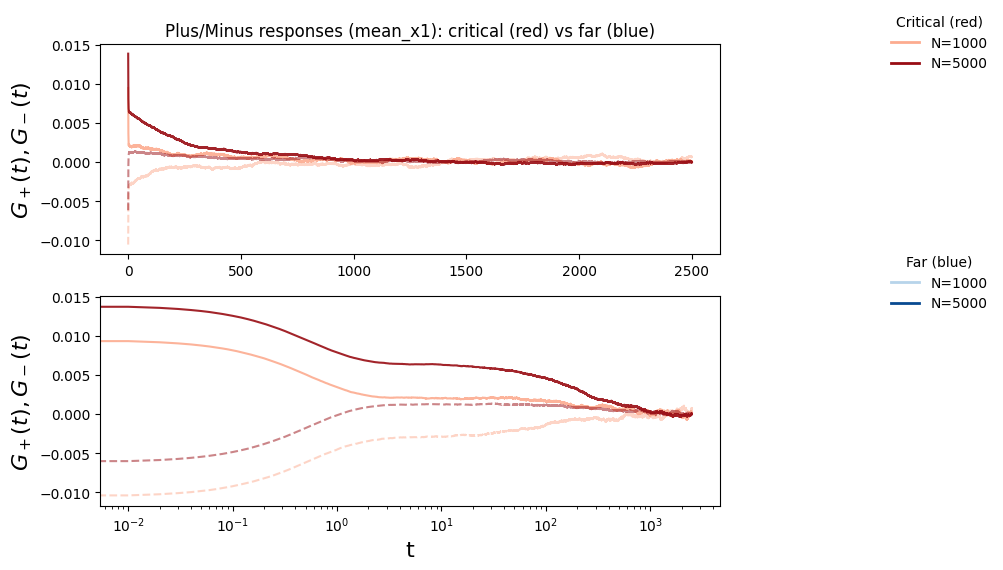

In [5]:
# Plot +epsilon and -epsilon responses (same color conventions as above)
repo_root = find_repo_root()

def plot_plus_minus_all_in_one():
    critical_dir = repo_root / 'results/linear_response/poisson/perturbed_runs/critical'
    far_dir = repo_root / 'results/linear_response/poisson/perturbed_runs/far'

    critical_data = _collect_response_series(critical_dir)
    far_data = _collect_response_series(far_dir)

    all_ns = sorted(set(critical_data.keys()) | set(far_data.keys()))
    red_map = _color_map(all_ns, 'Reds')
    blue_map = _color_map(all_ns, 'Blues')

    fig, (ax_lin, ax_log) = plt.subplots(nrows=2, figsize=(8, 6), sharex=False)
    ax_log.set_xscale('log')

    for n_val, runs in sorted(critical_data.items()):
        for eps_tag, graph_tag, df_plus, df_minus, eps, sample_count in runs:
            if 't' in df_plus.columns and 'mean_x1' in df_plus.columns:
                ax_lin.plot(df_plus['t'], df_plus['mean_x1'], color=red_map[n_val], alpha=0.9)
                ax_log.plot(df_plus['t'], df_plus['mean_x1'], color=red_map[n_val], alpha=0.9)
            if 't' in df_minus.columns and 'mean_x1' in df_minus.columns:
                ax_lin.plot(df_minus['t'], df_minus['mean_x1'], color=red_map[n_val], alpha=0.5, linestyle='--')
                ax_log.plot(df_minus['t'], df_minus['mean_x1'], color=red_map[n_val], alpha=0.5, linestyle='--')

    # for n_val, runs in sorted(far_data.items()):
    #     for eps_tag, graph_tag, df_plus, df_minus, eps, sample_count in runs:
    #         if 't' in df_plus.columns and 'mean_x1' in df_plus.columns:
    #             ax_lin.plot(df_plus['t'], df_plus['mean_x1'], color=blue_map[n_val], alpha=0.9)
    #             ax_log.plot(df_plus['t'], df_plus['mean_x1'], color=blue_map[n_val], alpha=0.9)
    #         if 't' in df_minus.columns and 'mean_x1' in df_minus.columns:
    #             ax_lin.plot(df_minus['t'], df_minus['mean_x1'], color=blue_map[n_val], alpha=0.5, linestyle='--')
    #             ax_log.plot(df_minus['t'], df_minus['mean_x1'], color=blue_map[n_val], alpha=0.5, linestyle='--')

    ax_lin.set_title('Plus/Minus responses (mean_x1): critical (red) vs far (blue)')
    ax_log.set_xlabel('t', size=16)
    ax_lin.set_ylabel(r'$G_+(t), G_-(t)$', size=16)
    ax_log.set_ylabel(r'$G_+(t), G_-(t)$', size=16)

    # Figure-level legend outside the subplots
    handles_red = [plt.Line2D([0], [0], color=red_map[n], lw=2) for n in sorted(all_ns)]
    handles_blue = [plt.Line2D([0], [0], color=blue_map[n], lw=2) for n in sorted(all_ns)]
    labels = [f'N={n}' for n in sorted(all_ns)]
    fig.legend(handles_red, labels, title='Critical (red)', loc='upper right', bbox_to_anchor=(1.25, 0.95), frameon=False)
    fig.legend(handles_blue, labels, title='Far (blue)', loc='upper right', bbox_to_anchor=(1.25, 0.55), frameon=False)
    plt.show()

plot_plus_minus_all_in_one()


In [6]:
from pprint import pprint
pprint(counts)

{'critical': {1000: {0.01: 56360, 0.02: 56590}, 5000: {0.01: 39750}},
 'far': {1000: {0.01: 100001, 0.02: 100001}, 5000: {0.01: 95301, 0.02: 100001}}}
